<a href="https://colab.research.google.com/github/MadsNL/AMLMain/blob/Mads/AML_IceCores_combined_train_on_everything_resnetstuff_bu_new_stuff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! gdown --id 1paSsYReykEVDPX8pA2SUf7Gr7Lptq-PX
! unzip Insoluables_TrainingData26May2022.zip
!git clone https://github.com/MadsNL/AMLpackages.git
import sys
sys.path.append('/content/AMLpackages/')
from load_data import training_set, not_training_set
from load_data import training_set_RGB
from Models import make_autoencoder
!pip install pyyaml h5py 
!pip install umap-learn

Streaming output truncated to the last 5000 lines.
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5532.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5533.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5534.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5535.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5536.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5537.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5538.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5539.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_554.png  
 extracting: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5540.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5541.png  
  inflating: Insoluables_T

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
#import umap
import seaborn as sb
import lightgbm as lgb
from sklearn.model_selection import train_test_split

In [3]:
sup_path = '/content/Insoluables_TrainingData/train/'
sup_im_path = '/content/Insoluables_TrainingData/train/'
sup_df = pd.read_csv(sup_path+'train.csv')
train_df, test_df = train_test_split(sup_df, test_size=0.2, random_state=37)
train = training_set_RGB(train_df, sup_im_path)
test = training_set_RGB(test_df, sup_im_path)

In [4]:
# save image_size
im_e, _, _ = train.__getitem__(0)
image_size = im_e.shape[0]
image_size

128

In [5]:
train_size = len(train.labels)
test_size = len(test.labels)

In [6]:
def make_NN_conv():
  image_size = 128

  conv_input = keras.Input(shape=(image_size,image_size,3))
  x = ResNet50(input_shape=(image_size, image_size,3), include_top=False, weights='imagenet', pooling='max')(conv_input)
  x = keras.layers.Flatten()(x)
  x = keras.layers.Dropout(0.2)(x)
  x = keras.layers.BatchNormalization(momentum=0.9, center=True, scale=True)(x)
  x = keras.layers.Dense(128, activation='relu')(x)
  x = keras.layers.Dropout(0.2)(x)
  x = keras.layers.BatchNormalization(momentum=0.9, center=True, scale=True)(x)
  conv_output = keras.layers.Dense(128)(x)

  meta_input = keras.Input(shape=(34))
  x = keras.layers.Dense(128, activation='relu')(meta_input)
  x = keras.layers.Dropout(0.2)(x)
  x = keras.layers.BatchNormalization(momentum=0.9, center=True, scale=True)(x)
  x = keras.layers.Dense(128, activation='relu')(x)
  x = keras.layers.Dropout(0.2)(x)
  x = keras.layers.BatchNormalization(momentum=0.9, center=True, scale=True)(x)
  meta_output = keras.layers.Dense(32, activation='relu')(x)

  combined = keras.layers.concatenate([conv_output, meta_output])

  x = keras.layers.Dense(128, activation='relu')(combined)
  x = keras.layers.Dropout(0.2)(x)
  x = keras.layers.BatchNormalization(momentum=0.9, center=True, scale=True)(x)
  x = keras.layers.Dense(64, activation='relu')(x)
  x = keras.layers.Dropout(0.2)(x)
  x = keras.layers.BatchNormalization(momentum=0.9, center=True, scale=True)(x)
  x = keras.layers.Dropout(0.2)(x)
  x = keras.layers.BatchNormalization(momentum=0.9, center=True, scale=True)(x)
  combined_output = keras.layers.Dense(7, activation='softmax')(x)

  model = keras.Model([conv_input, meta_input], combined_output)

  model.summary()

  opt = keras.optimizers.Adam(lr=0.001, decay=1e-6)

  model.compile(opt, loss='SparseCategoricalCrossentropy', metrics=['accuracy'])

  return model

In [7]:
NN = make_NN_conv()

94781440/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, 2048)         23587712    ['input_1[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 flatten (Flatten)           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [8]:
from keras.utils.vis_utils import plot_model

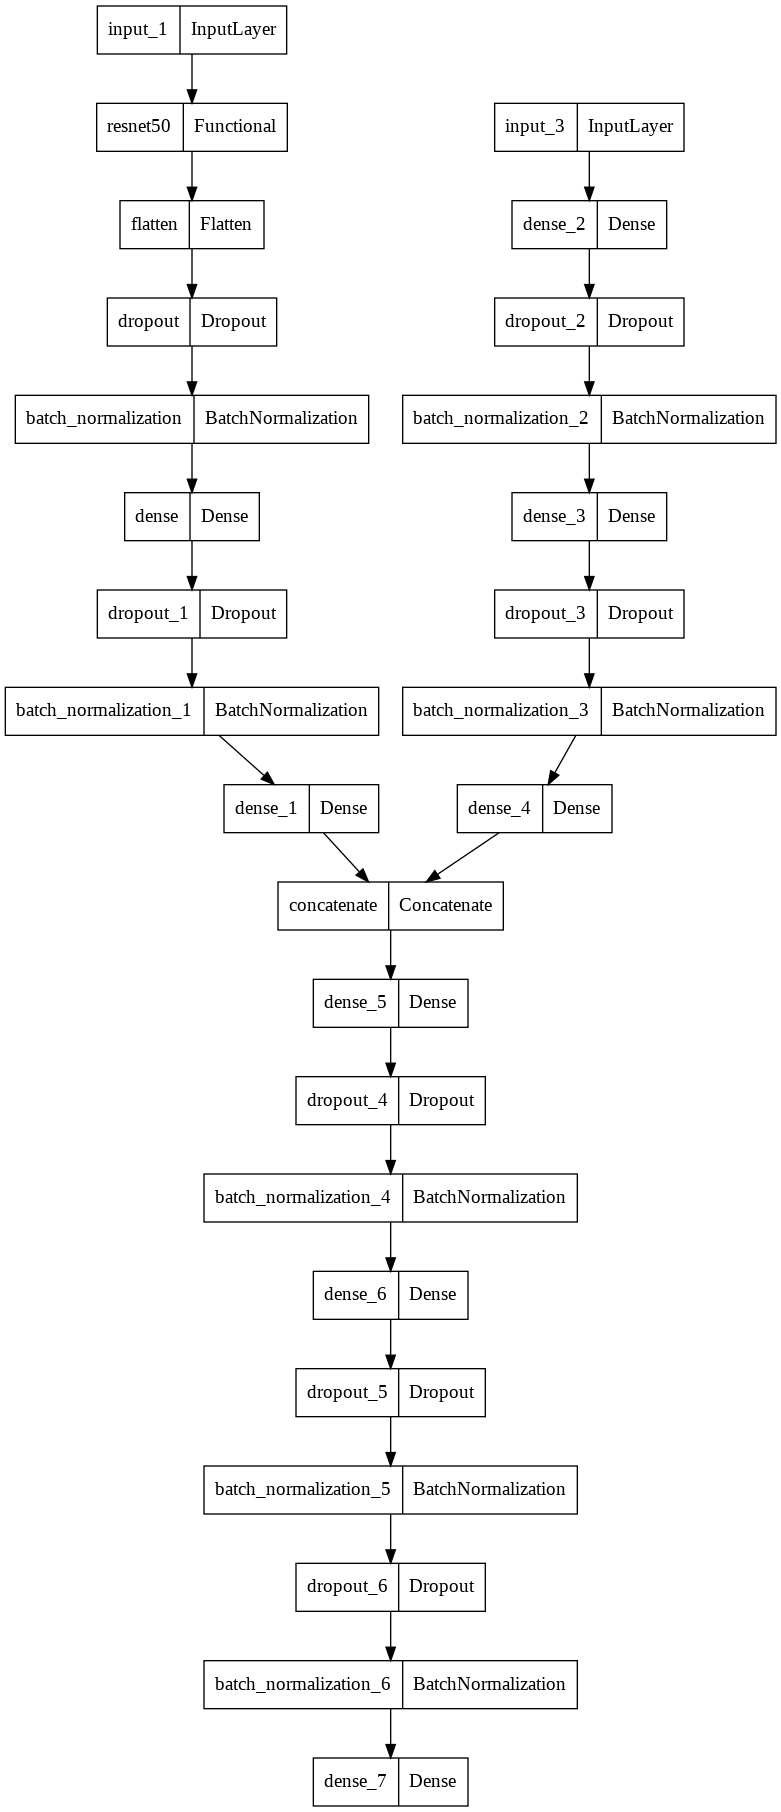

In [9]:
plot_model(NN)

In [10]:
train_increment = 5000
nr_trains = train_size//train_increment
#nr_trains_h = nr_trains//2
nr_trains=5
points_left_over = train_size % train_increment

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)

index_count = 0
for i in range(nr_trains):
  print(i, nr_trains)
  x_im = []
  x_lab = []
  x_feat = []
  for j in range(train_increment):
    im, lab, feat = train.__getitem__(index_count)
    index_count += 1
    x_im.append(im)
    x_lab.append(lab)
    x_feat.append(feat)

  x_im = np.array(x_im)
  x_lab = np.array(x_lab)
  x_feat = np.array(x_feat)

  NN.fit([x_im, x_feat], x_lab, epochs=200, batch_size=32, validation_split=0.1, callbacks=[callback])

  x_im = 0
  x_lab = 0
  x_feat = 0

x_im = 0
x_lab = 0
x_feat = 0

0 5
Epoch 1/200
141/141 [==============================] - 40s 142ms/step - loss: 1.1657 - accuracy: 0.6271 - val_loss: 1.3908 - val_accuracy: 0.5940
Epoch 2/200
141/141 [==============================] - 18s 129ms/step - loss: 0.8169 - accuracy: 0.7353 - val_loss: 1.3040 - val_accuracy: 0.5840
Epoch 3/200
141/141 [==============================] - 18s 131ms/step - loss: 0.7404 - accuracy: 0.7487 - val_loss: 1.3993 - val_accuracy: 0.5900
Epoch 4/200
141/141 [==============================] - 19s 135ms/step - loss: 0.6258 - accuracy: 0.7767 - val_loss: 1.2717 - val_accuracy: 0.6260
Epoch 5/200
141/141 [==============================] - 19s 134ms/step - loss: 0.5890 - accuracy: 0.7938 - val_loss: 1.3380 - val_accuracy: 0.6240
Epoch 6/200
141/141 [==============================] - 19s 133ms/step - loss: 0.5468 - accuracy: 0.8051 - val_loss: 0.8665 - val_accuracy: 0.7200
Epoch 7/200
141/141 [==============================] - 19s 131ms/step - loss: 0.4876 - accuracy: 0.8340 - val_loss: 0.88

In [11]:
x_im = 0
x_lab = 0
x_feat = 0

In [12]:
'''
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)
n = nr_trains-nr_trains_h
for i in range(n):
  print(i, n)
  x_im = []
  x_lab = []
  x_feat = []
  for j in range(train_increment):
    im, lab, feat = train.__getitem__(index_count)
    index_count += 1
    x_im.append(im)
    x_lab.append(lab)
    x_feat.append(feat)

  x_im = np.array(x_im)
  x_lab = np.array(x_lab)
  x_feat = np.array(x_feat)

  NN.fit([x_im, x_feat], x_lab, epochs=200, batch_size=32, validation_split=0.1, callbacks=[callback])

  x_im = 0
  x_lab = 0
  x_feat = 0

x_im = 0
x_lab = 0
x_feat = 0'''

"\ncallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)\nn = nr_trains-nr_trains_h\nfor i in range(n):\n  print(i, n)\n  x_im = []\n  x_lab = []\n  x_feat = []\n  for j in range(train_increment):\n    im, lab, feat = train.__getitem__(index_count)\n    index_count += 1\n    x_im.append(im)\n    x_lab.append(lab)\n    x_feat.append(feat)\n\n  x_im = np.array(x_im)\n  x_lab = np.array(x_lab)\n  x_feat = np.array(x_feat)\n\n  NN.fit([x_im, x_feat], x_lab, epochs=200, batch_size=32, validation_split=0.1, callbacks=[callback])\n\n  x_im = 0\n  x_lab = 0\n  x_feat = 0\n\nx_im = 0\nx_lab = 0\nx_feat = 0"

In [13]:
'''x_train = []
for i in range(points_left_over):
  im, _, _ = train.__getitem__(index_count)
  index_count += 1
  x_train.append(im)
x_train = np.array(x_train)
#autoencoder.fit(x_train, x_train, epochs=200, batch_size=32, validation_split=0.1, callbacks=[callback])
NN.fit([x_im, x_feat], x_lab, epochs=200, batch_size=32, validation_split=0.1, callbacks=[callback])

x_im = 0
x_lab = 0
x_feat = 0'''

'x_train = []\nfor i in range(points_left_over):\n  im, _, _ = train.__getitem__(index_count)\n  index_count += 1\n  x_train.append(im)\nx_train = np.array(x_train)\n#autoencoder.fit(x_train, x_train, epochs=200, batch_size=32, validation_split=0.1, callbacks=[callback])\nNN.fit([x_im, x_feat], x_lab, epochs=200, batch_size=32, validation_split=0.1, callbacks=[callback])\n\nx_im = 0\nx_lab = 0\nx_feat = 0'

In [14]:
#encoder.save('encoder_128_resnet')
#autoencoder.save('autoencoder_128_resnet')

In [15]:
'''!zip -r encoder_128_resnet.zip encoder_128_resnet/
!zip -r autoencoder_128_resnet.zip autoencoder_128_resnet/
from google.colab import files
files.download("encoder_128_resnet.zip")
files.download("autoencoder_128_resnet.zip")'''

'!zip -r encoder_128_resnet.zip encoder_128_resnet/\n!zip -r autoencoder_128_resnet.zip autoencoder_128_resnet/\nfrom google.colab import files\nfiles.download("encoder_128_resnet.zip")\nfiles.download("autoencoder_128_resnet.zip")'

In [16]:
'''NN.save('combined_resnet')
!zip -r combined_resnet.zip combined_resnet/
from google.colab import files 
files.download('combined_resnet.zip')'''

"NN.save('combined_resnet')\n!zip -r combined_resnet.zip combined_resnet/\nfrom google.colab import files \nfiles.download('combined_resnet.zip')"

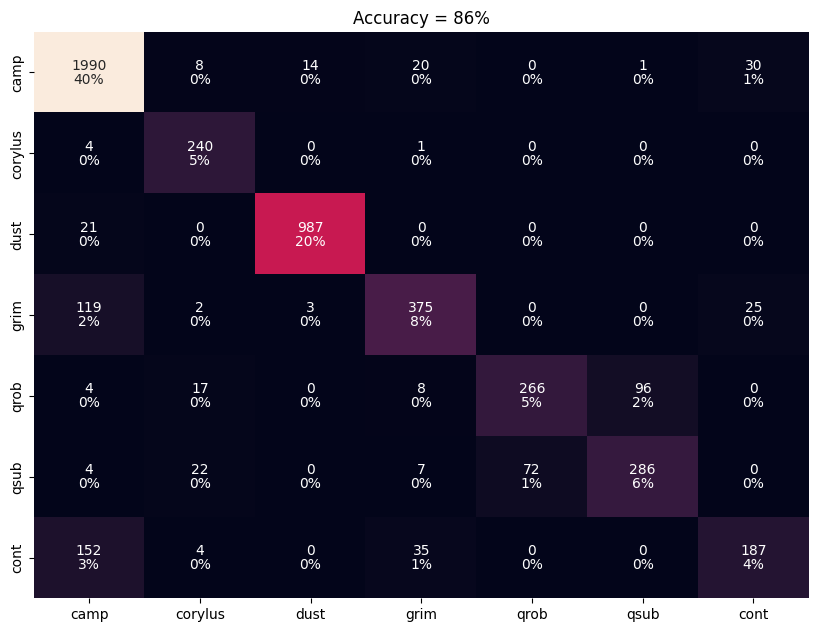

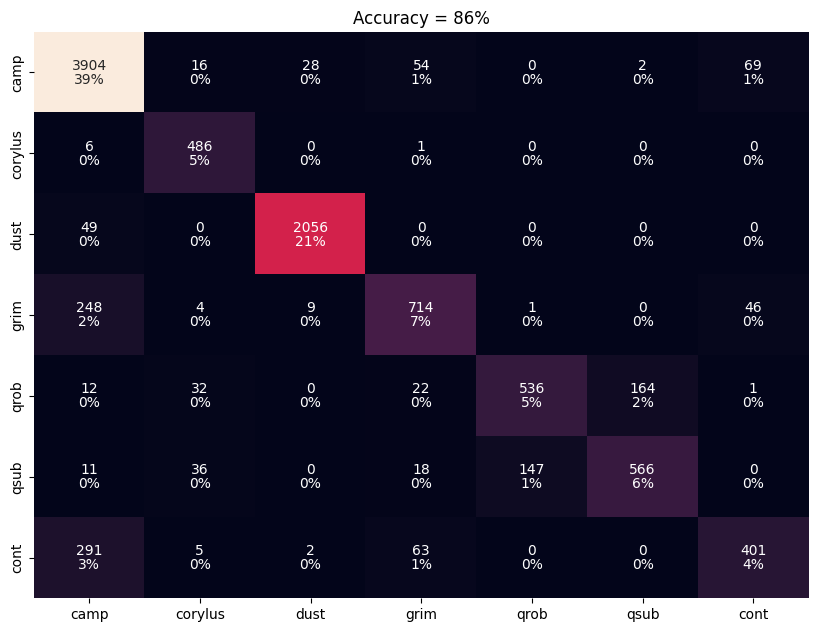

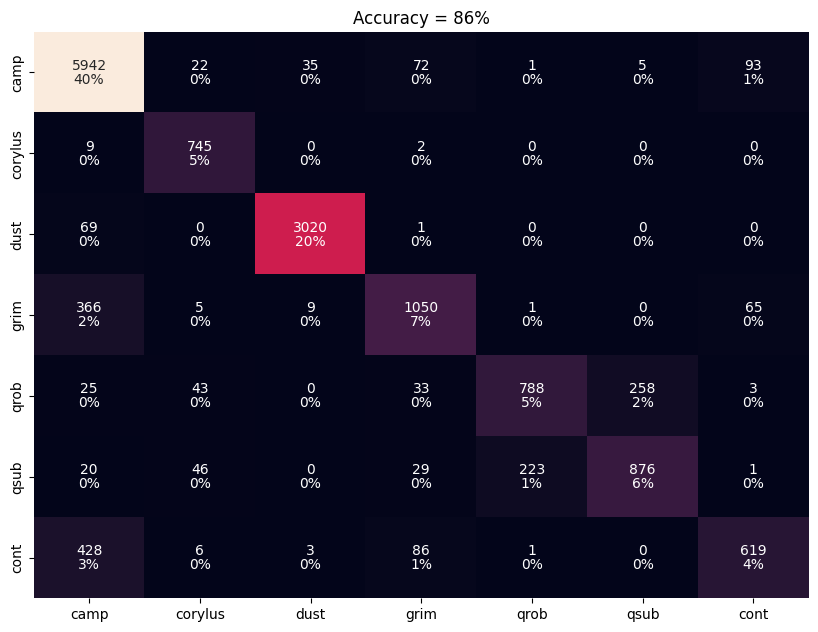

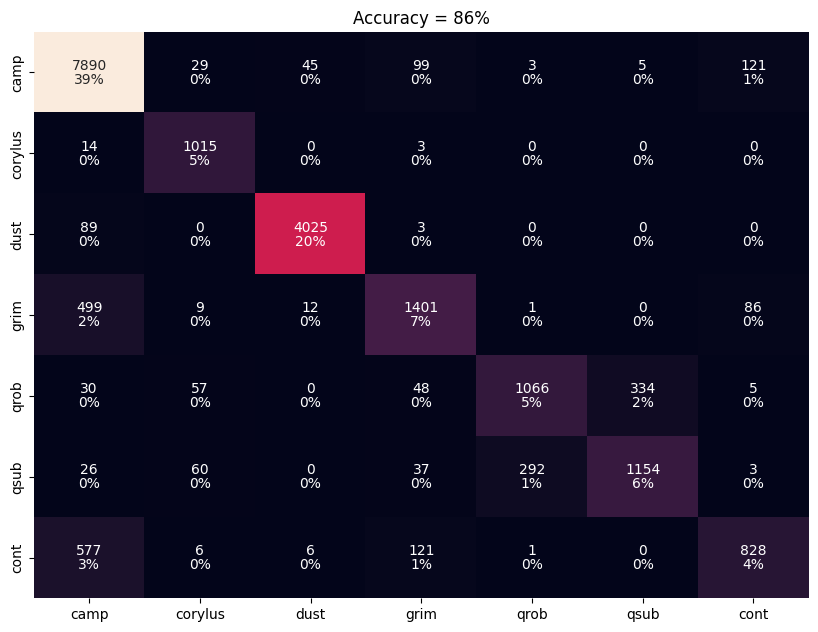

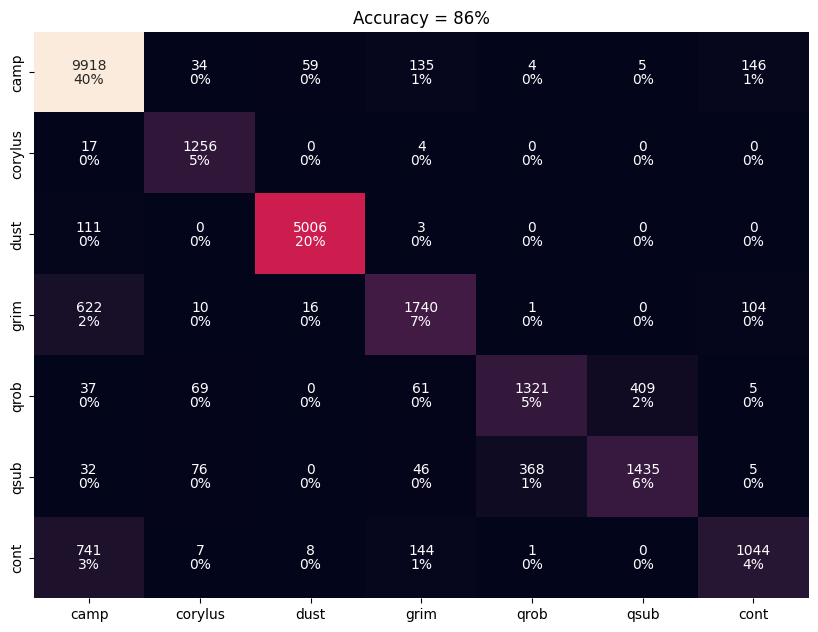

In [18]:
from sklearn.metrics import confusion_matrix
test_increment = 5000
nr_tests = test_size//test_increment
#nr_trains=1
points_left_over = test_size % test_increment

#callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)

all_preds = np.array([])
all_labs = np.array([])

index_count = 0
for i in range(nr_tests):
  x_im = []
  x_lab = []
  x_feat = []
  for j in range(train_increment):
    im, lab, feat = test.__getitem__(index_count)
    index_count += 1
    x_im.append(im)
    x_lab.append(lab)
    x_feat.append(feat)

  x_im = np.array(x_im)
  x_lab = np.array(x_lab)
  x_feat = np.array(x_feat)

  preds = np.argmax(NN.predict([x_im, x_feat]), axis=1)

  all_preds = np.append(all_preds, preds)
  all_labs = np.append(all_labs, x_lab)

  x_im = 0
  x_lab = 0
  x_feat = 0

  acc = sum(all_preds==all_labs)/len(all_labs) *100

  cm = confusion_matrix(all_labs, all_preds)
  cm_perc = cm/np.sum(cm)

  types = ['camp', 'corylus', 'dust', 'grim', 'qrob', 'qsub', 'cont']

  plt.figure(figsize=(10,7.5),dpi=100)
  plt.title('Accuracy = ' + str(int(acc)) + '%')
  sb.heatmap(cm, annot=False, cbar=False, xticklabels=types, yticklabels=types)
  sb.heatmap(cm, annot=True, annot_kws={'va':'bottom'}, fmt="", cbar=False, xticklabels=types, yticklabels=types)
  sb.heatmap(cm, annot=cm_perc, annot_kws={'va':'top'}, fmt=".0%", cbar=False, xticklabels=types, yticklabels=types)
  plt.savefig('combined_confusion.png')


In [ ]:
sum(all_preds==all_labs)/len(all_labs)